In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Navigate to the current directory
from google.colab import userdata
import os
os.chdir(userdata.get('CURRENT_DIR'))

Mounted at /content/drive


In [2]:
# General data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets
df_train = pd.read_csv('data/merged/news_SA_train.csv')
df_test = pd.read_csv('data/merged/news_SA_test.csv')
one_shot_news = pd.read_csv('data/merged/news_one_shot.csv')

In [4]:
df_train.head()

,ticker,sentiment,title,annot_title,date,source_dataset
0,AMZN,neutral,Stock Split Watch: Is ASML Next?,[TICKER] AMZN | [TITLE] Stock Split Watch: Is ...,2023-01-02,polygon_news_2023_raw
1,GOOG,neutral,Stock Split Watch: Is ASML Next?,[TICKER] GOOG | [TITLE] Stock Split Watch: Is ...,2023-01-02,polygon_news_2023_raw
2,AAPL,negative,Where Will The Trade Desk Stock Be in 5 Years?,[TICKER] AAPL | [TITLE] Where Will The Trade D...,2023-01-03,polygon_news_2023_raw
3,GOOG,neutral,Where Will The Trade Desk Stock Be in 5 Years?,[TICKER] GOOG | [TITLE] Where Will The Trade D...,2023-01-03,polygon_news_2023_raw
4,META,neutral,Where Will The Trade Desk Stock Be in 5 Years?,[TICKER] META | [TITLE] Where Will The Trade D...,2023-01-03,polygon_news_2023_raw


In [5]:
df_test.head()

,ticker,sentiment,title,annot_title,date,source_dataset
0,NFLX,positive,Should You Buy Netflix Stock Before Dec. 25?,[TICKER] NFLX | [TITLE] Should You Buy Netflix...,2024-12-07,polygon_news_2024_raw
1,AMZN,neutral,Is Costco Stock a Buy for 2025?,[TICKER] AMZN | [TITLE] Is Costco Stock a Buy ...,2024-12-07,polygon_news_2024_raw
2,GOOG,neutral,1 Growth Stock Down 60% to Buy Right Now,[TICKER] GOOG | [TITLE] 1 Growth Stock Down 60...,2024-12-07,polygon_news_2024_raw
3,META,positive,"Stock Markets Extends Record Highs, US Labor M...",[TICKER] META | [TITLE] Stock Markets Extends ...,2024-12-07,polygon_news_2024_raw
4,AMZN,positive,"Stock Markets Extends Record Highs, US Labor M...",[TICKER] AMZN | [TITLE] Stock Markets Extends ...,2024-12-07,polygon_news_2024_raw


In [6]:
one_shot_news

,ticker,sentiment,title,annot_title,date,source_dataset
0,AMZN,positive,Billionaire David Tepper Has 14% of His Portfo...,[TICKER] AMZN | [TITLE] Billionaire David Tepp...,2024-12-07,polygon_news_2024_raw
1,AAPL,negative,Warren Buffett Has Sold $133 Billion Worth of ...,[TICKER] AAPL | [TITLE] Warren Buffett Has Sol...,2024-12-07,polygon_news_2024_raw
2,AAPL,neutral,1 Growth Stock Down 60% to Buy Right Now,[TICKER] AAPL | [TITLE] 1 Growth Stock Down 60...,2024-12-07,polygon_news_2024_raw


In [7]:
df_train.duplicated(subset=['annot_title']).sum()

np.int64(0)

In [8]:
df_test.duplicated(subset=['annot_title']).sum()

np.int64(0)

In [9]:
# View the class distribution
df_train['sentiment'].value_counts()

,count
sentiment,
positive,2126
neutral,1071
negative,336


In [10]:
df_test['sentiment'].value_counts()

,count
sentiment,
neutral,2599
positive,1423
negative,169


In [11]:
df_train.shape, df_test.shape

((3533, 6), (4191, 6))

The train set and test set share similar imbalances: both have few negative news pieces in comparison to positive & neutral news

In [12]:
!pip install --upgrade langchain_huggingface torch transformers accelerate sentence_transformers langchain-huggingface bitsandbytes evaluate tokenizers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 20.0.0 which is incompatible.


In [13]:
# Set a particular seed for torch to ensure reproducibility
import torch
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(83)

In [14]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
GPU Name: NVIDIA L4


In [15]:
# Pytorch configs
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [16]:
# Define label-id mappings
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# 1. Data Cleaning (for transformers)

In [17]:
!pip install contractions

In [18]:
import re
import contractions

# Define a function to clean text for transformers
def clean_text(text):
	# Replace multiple whitespaces with just one
    text = re.sub(r"\s+", " ", text)

    # Replace URLs with tag <URL>
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                  "<URL>", text)

	# Expand contractions in the text
    text = contractions.fix(text)

    return text

In [19]:
# Apply clean_text on both the train set and the test set
df_train['annot_title'] = df_train['annot_title'].apply(clean_text)
df_test['annot_title'] = df_test['annot_title'].apply(clean_text)

In [20]:
# Rename the columns in the dataset to "text" and "labels" as BERT models expect columns with that specific name
df_train = df_train.rename(columns={"annot_title": "text", "sentiment": "labels"})
df_test = df_test.rename(columns={"annot_title": "text", "sentiment": "labels"})

# 2. BERT

Here I utilize the original BERT model to establish commonality with previous research in the field

In [21]:
from transformers import BertForSequenceClassification, BertTokenizerFast, BertConfig
model_name = "google-bert/bert-base-cased"

tokenizer = BertTokenizerFast.from_pretrained(
    model_name,
    use_fast=True,
    padding_side="left",
    padding_token='[PAD]'
)

config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,
    label2id=label2id,
    id2label=id2label,
)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    device_map="auto",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2.1. Out-of-the-box

In [22]:
from transformers import pipeline

bert_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=3 # 3 output classes
)

Device set to use cuda:0


In [23]:
# Try with one entry first
bert_classifier(df_test['text'].iloc[1])

[[{'label': 'negative', 'score': 0.4447932541370392},
  {'label': 'positive', 'score': 0.3256649971008301},
  {'label': 'neutral', 'score': 0.22954179346561432}]]

In [24]:
# Apply on the whole validation set
raw_bert_predictions = bert_classifier(df_test['text'].to_list())

In [25]:
# Create a function that takes in the list of scores and return the extracted & overall scores
def extract_scores(score_list):
    for score in score_list:
        if score['label'] == 'negative':
            negative_score = score['score']
        elif score['label'] == 'neutral':
            neutral_score = score['score']
        elif score['label'] == 'positive':
            positive_score = score['score']
    overall_score = max(negative_score, neutral_score, positive_score)
    return negative_score, neutral_score, positive_score, overall_score

In [26]:
# Transform raw_bert_predictions into a DataFrame with the 4 scores
raw_bert_predictions = pd.DataFrame({"score_list" : raw_bert_predictions})
raw_bert_predictions["negative_score"], raw_bert_predictions["neutral_score"], raw_bert_predictions["positive_score"], raw_bert_predictions["overall_score"] = zip(*raw_bert_predictions["score_list"].apply(extract_scores))
raw_bert_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"[{'label': 'negative', 'score': 0.433617085218...",0.433617,0.226134,0.340249,0.433617
1,"[{'label': 'negative', 'score': 0.444793254137...",0.444793,0.229542,0.325665,0.444793
2,"[{'label': 'negative', 'score': 0.429350882768...",0.429351,0.233850,0.336799,0.429351
3,"[{'label': 'negative', 'score': 0.459873259067...",0.459873,0.227708,0.312419,0.459873
4,"[{'label': 'negative', 'score': 0.457111269235...",0.457111,0.227812,0.315077,0.457111


In [27]:
# Save the predicted results
raw_bert_predictions.loc[:, raw_bert_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_bert_predictions.csv", index=False)

In [28]:
# Create a function to calculate the metrics from the predicted values (this will be reused for Llama models)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def get_metrics(df):
    preds = np.argmax(df[["negative_score", "neutral_score", "positive_score"]].to_numpy(), axis=1)
    labels = df_test['labels'].map(label2id)

    # Overall accuracy
    accuracy = accuracy_score(labels, preds)

    # Precision, recall, f1, support for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0.0
    )

    # Weighted average
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0.0
    )

    # Build result dictionary
    results = {
        "accuracy": accuracy,
        "precision_weighted": precision_w,
        "recall_weighted": recall_w,
        "f1_weighted": f1_w,
    }

    # Add per-class metrics
    for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
        results[f"class_{i}_precision"] = p
        results[f"class_{i}_recall"] = r
        results[f"class_{i}_f1"] = f
        results[f"class_{i}_support"] = s

    return results

In [29]:
# Get the metrics
results = get_metrics(raw_bert_predictions)
print(results)

{'accuracy': 0.04032450489143403, 'precision_weighted': 0.0016260656947392868, 'recall_weighted': 0.04032450489143403, 'f1_weighted': 0.003126074003051537, 'class_0_precision': np.float64(0.04032450489143403), 'class_0_recall': np.float64(1.0), 'class_0_f1': np.float64(0.07752293577981652), 'class_0_support': np.int64(169), 'class_1_precision': np.float64(0.0), 'class_1_recall': np.float64(0.0), 'class_1_f1': np.float64(0.0), 'class_1_support': np.int64(2599), 'class_2_precision': np.float64(0.0), 'class_2_recall': np.float64(0.0), 'class_2_f1': np.float64(0.0), 'class_2_support': np.int64(1423)}


In [30]:
# Save the metrics
pd.DataFrame(results, index=[0]).to_csv("sentiment_scores/raw_bert_metrics.csv", index=False)

## 2.2. Fine-tuned

In [31]:
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
dataset_train = Dataset.from_pandas(df_train[['text', 'labels']])
dataset_val = Dataset.from_pandas(df_test[['text', 'labels']])

dataset_train = dataset_train.map(lambda examples: {'labels': [label2id[label] for label in examples['labels']]}, batched=True)
dataset_val = dataset_val.map(lambda examples: {'labels': [label2id[label] for label in examples['labels']]}, batched=True)

# Define function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# Apply tokenize_function to train and validation sets with batching (faster)
tokenized_train_set = dataset_train.map(tokenize_function, batched=True)
tokenized_val_set = dataset_val.map(tokenize_function, batched=True)
tokenized_train_set, tokenized_val_set

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/4191 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/4191 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 3533
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 4191
 }))

In [32]:
from transformers import Trainer, TrainingArguments, TrainerCallback, DataCollatorWithPadding

# Define a custom callback that collects loss value at each logging step
class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            # print(f"Step {state.global_step}, Loss: {logs['loss']}")
            self.losses.append((state.global_step, logs["loss"]))

# Define a data collator to batch samples during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a function to calculate the performance metrics during evaluations
def bert_compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)

    # Overall accuracy
    accuracy = accuracy_score(labels, preds)

    # Precision, recall, f1, support for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0.0
    )

    # Weighted average
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0.0
    )

    # Build result dictionary
    results = {
        "accuracy": accuracy,
        "precision_weighted": precision_w,
        "recall_weighted": recall_w,
        "f1_weighted": f1_w,
    }

    # Add per-class metrics
    for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
        results[f"class_{i}_precision"] = p
        results[f"class_{i}_recall"] = r
        results[f"class_{i}_f1"] = f
        results[f"class_{i}_support"] = s

    return results


In [34]:
# Define the training arguments
# I include the eval dataset for ease of evaluation, but to keep the model design consistent with Llama, I don't actually call evaluation during training
bert_training_args = TrainingArguments(
    output_dir="./results/bert",
    logging_dir="./logs/bert",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
bert_trainer = Trainer(
    model=model,
    args=bert_training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_val_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=bert_compute_metrics,
    callbacks=[loss_callback]
)

<ipython-input-34-8c36d29bbf79>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert_trainer = Trainer(


In [35]:
# Train the model
bert_trainer.train()

Step,Training Loss
50,0.978100
100,0.911500
150,0.846300
200,0.821200
250,0.795600
300,0.720000
350,0.707200
400,0.678200
450,0.669300
500,0.535900


TrainOutput(global_step=1105, training_loss=0.5645043893097752, metrics={'train_runtime': 138.6599, 'train_samples_per_second': 127.398, 'train_steps_per_second': 7.969, 'total_flos': 798857558840880.0, 'train_loss': 0.5645043893097752, 'epoch': 5.0})

In [36]:
# Evaluate the model
bert_metrics = bert_trainer.evaluate()
print(bert_metrics)

{'eval_loss': 1.3931822776794434, 'eval_accuracy': 0.49964209019327127, 'eval_precision_weighted': 0.593817519364376, 'eval_recall_weighted': 0.49964209019327127, 'eval_f1_weighted': 0.49672576723719786, 'eval_class_0_precision': 0.15846994535519127, 'eval_class_0_recall': 0.17159763313609466, 'eval_class_0_f1': 0.16477272727272727, 'eval_class_0_support': 169, 'eval_class_1_precision': 0.7252906976744186, 'eval_class_1_recall': 0.38399384378607154, 'eval_class_1_f1': 0.5021383647798742, 'eval_class_1_support': 2599, 'eval_class_2_precision': 0.4053951367781155, 'eval_class_2_recall': 0.7498243148278285, 'eval_class_2_f1': 0.5262638717632553, 'eval_class_2_support': 1423, 'eval_runtime': 12.5052, 'eval_samples_per_second': 335.14, 'eval_steps_per_second': 41.902, 'epoch': 5.0}


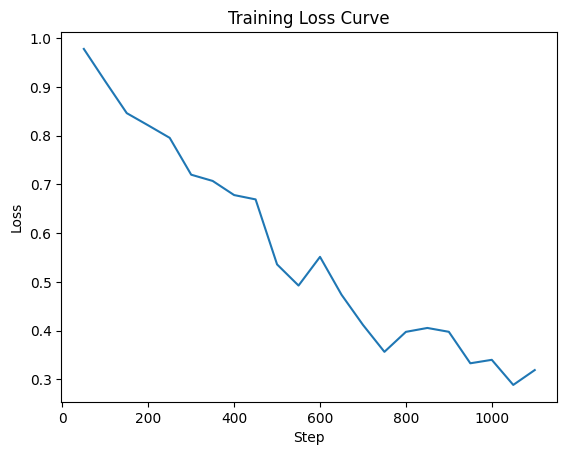

In [37]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [38]:
# Let the trainer make the predictions on the test set
predictions = bert_trainer.predict(tokenized_val_set)

# Get the predicted logits
logits = predictions.predictions

In [39]:
from torch.nn import functional as F

# Convert logit score to torch array
torch_logits = torch.from_numpy(logits)

# Get probabilities using softmax from logit score and convert it to numpy vectors
finetuned_bert_predictions = F.softmax(torch_logits, dim = -1).numpy()

In [40]:
finetuned_bert_predictions[0]

array([0.00487679, 0.11694836, 0.87817484], dtype=float32)

In [41]:
finetuned_bert_predictions = pd.DataFrame(finetuned_bert_predictions, columns=["negative_score", "neutral_score", "positive_score"])
finetuned_bert_predictions["overall_score"] = finetuned_bert_predictions["positive_score"] - finetuned_bert_predictions["negative_score"]
finetuned_bert_predictions.head()

,negative_score,neutral_score,positive_score,overall_score
0,0.004877,0.116948,0.878175,0.873298
1,0.085837,0.434113,0.480050,0.394213
2,0.017958,0.933749,0.048293,0.030335
3,0.003885,0.017159,0.978955,0.975070
4,0.003637,0.015134,0.981229,0.977592


In [42]:
# Save the predictions
finetuned_bert_predictions.to_csv("sentiment_scores/finetuned_bert_predictions.csv", index=False)

In [43]:
# Save the model metrics
pd.DataFrame(bert_metrics, index=[0]).to_csv("sentiment_scores/finetuned_bert_metrics.csv", index=False)

# 3. FinBERT

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizerFast, BertConfig
model_name = "ProsusAI/finbert"

tokenizer = BertTokenizerFast.from_pretrained(
    model_name,
    use_fast=True,
    padding_side="left",
    padding_token='[PAD]'
)

config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,
    label2id=label2id,
    id2label=id2label,
)

model = BertForSequenceClassification.from_pretrained(
    model_name,
    config=config,
    device_map="auto",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## 3.1. Out-of-the-box

In [ ]:
from transformers import pipeline

finbert_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=3
)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Try with one entry first
finbert_classifier(df_test['text'].iloc[1])

[[{'label': 'positive', 'score': 0.9231074452400208},
  {'label': 'negative', 'score': 0.05956728011369705},
  {'label': 'neutral', 'score': 0.017325283959507942}]]

In [ ]:
# Apply on the whole validation set
raw_finbert_predictions = finbert_classifier(df_test['text'].to_list())

In [ ]:
# Transform raw_finbert_predictions into a DataFrame with the 4 scores
raw_finbert_predictions = pd.DataFrame({"score_list" : raw_finbert_predictions})
raw_finbert_predictions["negative_score"], raw_finbert_predictions["neutral_score"], raw_finbert_predictions["positive_score"], raw_finbert_predictions["overall_score"] = zip(*raw_finbert_predictions["score_list"].apply(extract_scores))
raw_finbert_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"[{'label': 'positive', 'score': 0.945295095443...",0.031062,0.023643,0.945295,0.945295
1,"[{'label': 'positive', 'score': 0.923107445240...",0.059567,0.017325,0.923107,0.923107
2,"[{'label': 'neutral', 'score': 0.9350420236587...",0.015951,0.935042,0.049007,0.935042
3,"[{'label': 'negative', 'score': 0.850594580173...",0.850595,0.040358,0.109047,0.850595
4,"[{'label': 'negative', 'score': 0.861295998096...",0.861296,0.053018,0.085686,0.861296


In [ ]:
# Save the predicted results
raw_finbert_predictions.loc[:, raw_finbert_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_finbert_predictions.csv", index=False)

In [ ]:
# Get the metrics
results = get_metrics(raw_bert_predictions)
print(results)

{'accuracy': 0.325697924123121, 'precision_weighted': 0.5486306362700449, 'recall_weighted': 0.325697924123121, 'f1_weighted': 0.2900841086044016, 'class_0_precision': np.float64(0.02278481012658228), 'class_0_recall': np.float64(0.10650887573964497), 'class_0_f1': np.float64(0.03753910323253389), 'class_0_support': np.int64(169), 'class_1_precision': np.float64(0.6914660831509847), 'class_1_recall': np.float64(0.12158522508657175), 'class_1_f1': np.float64(0.20680628272251309), 'class_1_support': np.int64(2599), 'class_2_precision': np.float64(0.3502038043478261), 'class_2_recall': np.float64(0.724525650035137), 'class_2_f1': np.float64(0.47217769635905654), 'class_2_support': np.int64(1423)}


In [ ]:
# Save the metrics
pd.DataFrame(results, index=[0]).to_csv("sentiment_scores/raw_finbert_metrics.csv", index=False)

## 3.2. Fine-tuned

In [ ]:
from datasets import Dataset

# Define function to tokenize the dataset (finbert tokenizer != bert tokenizer)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# Apply tokenize_function to train and validation sets with batching (faster)
tokenized_train_set = dataset_train.map(tokenize_function, batched=True)
tokenized_val_set = dataset_val.map(tokenize_function, batched=True)
tokenized_train_set, tokenized_val_set

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/4191 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/4191 [00:00<?, ? examples/s]

(Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 3533
 }),
 Dataset({
     features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 4191
 }))

In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback, DataCollatorWithPadding

# Define a custom callback that collects loss value at each logging step
class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            # print(f"Step {state.global_step}, Loss: {logs['loss']}")
            self.losses.append((state.global_step, logs["loss"]))

# Define a data collator to batch samples during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define the training arguments (identical to bert's except for dirs)
finbert_training_args = TrainingArguments(
    output_dir="./results/finbert",
    logging_dir="./logs/finbert",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
finbert_trainer = Trainer(
    model=model,
    args=finbert_training_args,
    train_dataset=tokenized_train_set,
    eval_dataset=tokenized_val_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=bert_compute_metrics, # Use the same one as finetuned_bert
    callbacks=[loss_callback]
)

<ipython-input-34-cb33103cadc3>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  finbert_trainer = Trainer(


In [ ]:
# Train the model
finbert_trainer.train()

Step,Training Loss
50,1.088600
100,0.905700
150,0.815300
200,0.778200
250,0.771200
300,0.685500
350,0.676500
400,0.640300
450,0.636500
500,0.511200


TrainOutput(global_step=1105, training_loss=0.5460038502291856, metrics={'train_runtime': 92.2616, 'train_samples_per_second': 191.467, 'train_steps_per_second': 11.977, 'total_flos': 721115766196560.0, 'train_loss': 0.5460038502291856, 'epoch': 5.0})

In [ ]:
# Evaluate the model
finbert_metrics = finbert_trainer.evaluate()
print(finbert_metrics)

{'eval_loss': 1.5580790042877197, 'eval_accuracy': 0.4931997136721546, 'eval_precision_weighted': 0.607288750732194, 'eval_recall_weighted': 0.4931997136721546, 'eval_f1_weighted': 0.4842694991426615, 'eval_class_0_precision': 0.1417624521072797, 'eval_class_0_recall': 0.21893491124260356, 'eval_class_0_f1': 0.17209302325581396, 'eval_class_0_support': 169, 'eval_class_1_precision': 0.7416943521594684, 'eval_class_1_recall': 0.34359368988072336, 'eval_class_1_f1': 0.4696292400736261, 'eval_class_1_support': 2599, 'eval_class_2_precision': 0.41709464416727804, 'eval_class_2_recall': 0.7990161630358398, 'eval_class_2_f1': 0.5480838756326826, 'eval_class_2_support': 1423, 'eval_runtime': 11.8947, 'eval_samples_per_second': 352.342, 'eval_steps_per_second': 44.053, 'epoch': 5.0}


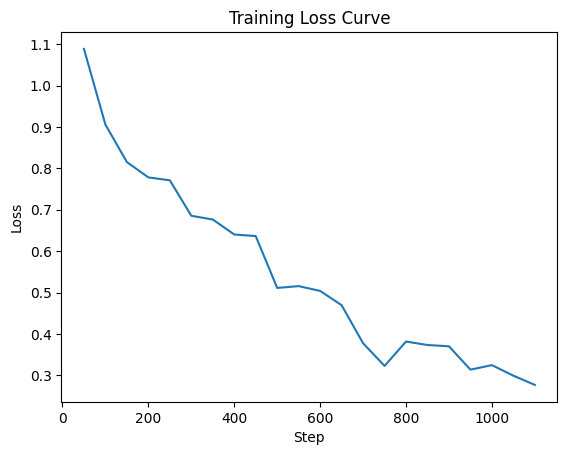

In [ ]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
# Let the trainer make the predictions on the test set
predictions = finbert_trainer.predict(tokenized_val_set)

# Get the predicted logits
logits = predictions.predictions

In [ ]:
from torch.nn import functional as F

# Convert logit score to torch array
torch_logits = torch.from_numpy(logits)

# Get probabilities using softmax from logit score and convert it to numpy vectors
finetuned_finbert_predictions = F.softmax(torch_logits, dim = -1).numpy()

In [ ]:
finetuned_finbert_predictions[0]

array([0.00729019, 0.24617954, 0.74653023], dtype=float32)

In [ ]:
finetuned_finbert_predictions = pd.DataFrame(finetuned_finbert_predictions, columns=["negative_score", "neutral_score", "positive_score"])
finetuned_finbert_predictions["overall_score"] = finetuned_finbert_predictions["positive_score"] - finetuned_finbert_predictions["negative_score"]
finetuned_finbert_predictions.head()

,negative_score,neutral_score,positive_score,overall_score
0,0.007290,0.246180,0.746530,0.739240
1,0.031595,0.659880,0.308525,0.276930
2,0.016452,0.838903,0.144645,0.128193
3,0.007489,0.008705,0.983806,0.976316
4,0.007661,0.008405,0.983934,0.976273


In [ ]:
# Save the predictions
finetuned_finbert_predictions.to_csv("sentiment_scores/finetuned_finbert_predictions.csv", index=False)

In [ ]:
# Save the model metrics
pd.DataFrame(finbert_metrics, index=[0]).to_csv("sentiment_scores/finetuned_finbert_metrics.csv", index=False)

# 4. Llama-3.2-3B-Instruct

In [ ]:
# This is to delete CUDA cache
try:
    del tokenizer
except:
    print("tokenizer already deleted")

try:
    del model
except:
    print("model already deleted")

try:
    del lora_model
except:
    print("lora_model already deleted")

import gc
torch.cuda.empty_cache()
gc.collect()

lora_model already deleted


30

In [ ]:
from huggingface_hub import login

login(userdata.get("LLAMA_TOKEN"))

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, BitsAndBytesConfig
import torch

model_name = "meta-llama/Llama-3.2-3B-Instruct"

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    padding_side="left",
)
tokenizer.pad_token_id = tokenizer.bos_token_id

config = AutoConfig.from_pretrained(
    model_name,
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True # Enable CPU offloading, Llama might be heavy
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
tokenizer.pad_token

'<|begin_of_text|>'

In [ ]:
one_shot_news

,ticker,sentiment,title,annot_title,date,source_dataset
0,AMZN,positive,Billionaire David Tepper Has 14% of His Portfo...,[TICKER] AMZN | [TITLE] Billionaire David Tepp...,2024-12-07,polygon_news_2024_raw
1,AAPL,negative,Warren Buffett Has Sold $133 Billion Worth of ...,[TICKER] AAPL | [TITLE] Warren Buffett Has Sol...,2024-12-07,polygon_news_2024_raw
2,AAPL,neutral,1 Growth Stock Down 60% to Buy Right Now,[TICKER] AAPL | [TITLE] 1 Growth Stock Down 60...,2024-12-07,polygon_news_2024_raw


Here, I define a function to construct the prompt for the model. Note that Llama 3.2 follows a different prompt format than Llama 2: https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/text_prompt_format.md

In [ ]:
# Construct the prompt format for model inference
def formatted_prompt(news_headline, shots=0):
    # Define special tokens to be inserted into the prompt
    B_SYS = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    E_SYS = "<|end_of_text|>"
    B_INST = "<|start_header_id|>user<|end_header_id|>"
    E_INST = "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    system_prompt = (
        "You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. "
        "Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. "
        "You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. "
        "The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. " # The space before each label is intentional
        "Answer with only one of these three labels and nothing else."
    )

    if shots == 0:
        user_prompt = (
            "Classify the sentiment of the following financial news headline into one of the following: "
            "' positive', ' neutral', or ' negative'.\n\n"
            f"{news_headline}\nSentiment:"
        )
    elif shots == 1:
        user_prompt = (
            "Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:\n\n"
            f"{one_shot_news['annot_title'][0]}\nSentiment: {one_shot_news['sentiment'][0]}\n\n"
            f"{one_shot_news['annot_title'][1]}\nSentiment: {one_shot_news['sentiment'][1]}\n\n"
            f"{one_shot_news['annot_title'][2]}\nSentiment: {one_shot_news['sentiment'][2]}\n\n"
            "Classify the sentiment of the following financial news headline into one of the following: "
            "' positive', ' neutral', or ' negative'.\n\n"
            f"{news_headline}\nSentiment:"
        )
    else:
        print("Unsupported number of shots")
        return None

    return f"{B_SYS}{system_prompt}{E_SYS}{B_INST}{user_prompt}{E_INST}"

In [ ]:
# Try one 1 entry
print(formatted_prompt(df_test['text'].iloc[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Classify the sentiment of the following financial news headline into one of the following: ' positive', ' neutral', or ' negative'.

[TICKER] NFLX | [TITLE] Should You Buy Netflix Stock Before December 25?
Sentiment:<|eot_id|><|start_header_id|>assistant<|end_header_id|>


In [ ]:
print(formatted_prompt(df_test['text'].iloc[2], shots=1))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:

[TICKER] AMZN | [TITLE] Billionaire David Tepper Has 14% of His Portfolio Invested in These 2 Brilliant Artificial Intelligence (AI) Stocks
Sentiment: positive

[TICKER] AAPL | [TITLE] Warren Buffett Has Sold $133 Billion Worth of Stock in 2024 So Far, but This Small $550 Million Purchase

In [ ]:
# Demonstrating the expected behavior of Llama tokenizer: It tokenizes the space before each word as well
# I spent an UNGODLY amount of time working this out
encoding = tokenizer("The product was great. Sentiment: positive", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

encoding = tokenizer(" positive", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

encoding = tokenizer(" Sentiment:", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

print(tokenizer(":", return_tensors="pt"))

['<|begin_of_text|>', 'The', 'Ġproduct', 'Ġwas', 'Ġgreat', '.', 'ĠSent', 'iment', ':', 'Ġpositive']
['<|begin_of_text|>', 'Ġpositive']
['<|begin_of_text|>', 'ĠSent', 'iment', ':']
{'input_ids': tensor([[128000,     25]]), 'attention_mask': tensor([[1, 1]])}


In [ ]:
# Get the tokenized label ids
labels = [" negative", " neutral", " positive"] # Add space before word because Llama tokenizer tokenize the words this way. Seriously, WHY?????
tokenized_labels = [tokenizer(label, add_special_tokens=False) for label in labels]
tokenized_label_ids = [tokenized_label.input_ids[0] for tokenized_label in tokenized_labels]
tokenized_label_ids_to_classes = {tok_id: i for i, tok_id in enumerate(tokenized_label_ids)}

In [ ]:
tokenized_label_ids

[8389, 21277, 6928]

In [ ]:
tokenized_label_ids_to_classes

{8389: 0, 21277: 1, 6928: 2}

## 4.1. Out-of-the-box

To get the sentiment scores for each class labels, I will obtain the log likelihood at the final layer of Llama instead of the output itself

In [ ]:
tokenized_label_ids

[8389, 21277, 6928]

In [ ]:
import torch.nn.functional as F

# Try on 1 entry first
prompt = formatted_prompt(df_test['text'].iloc[0])

log_likelihoods = []

# Tokenize the prompt
prompt_inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Get logits of all English vocab for the next token prediction
with torch.no_grad():
    outputs = model(**prompt_inputs)
    next_token_logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]
    log_probs = F.log_softmax(next_token_logits, dim=-1)

# Get the log-prob of the 3 labels
for tokenized_label_id in tokenized_label_ids:
    log_likelihoods.append(log_probs[0, tokenized_label_id].item())

# Convert to probabilities
probs = F.softmax(torch.tensor(log_likelihoods), dim=0)

# Output
for label, prob in zip(labels, probs):
    print(f"{label}: {prob.item():.4f}")

 negative: 0.3181
 neutral: 0.3157
 positive: 0.3662


In [ ]:
# Create a function to automate the above process
import torch.nn.functional as F

def get_sentiment_scores(prompt, tokenizer, model):
    log_likelihoods = []

    # Tokenize the prompt
    prompt_inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Get logits of all English vocab for the next token prediction
    with torch.no_grad():
        outputs = model(**prompt_inputs)
        next_token_logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]
        log_probs = F.log_softmax(next_token_logits, dim=-1)

    # Get the log-prob of the 3 labels
    for tokenized_label_id in tokenized_label_ids:
        log_likelihoods.append(log_probs[0, tokenized_label_id].item())

    # Convert to probabilities
    probs = F.softmax(torch.tensor(log_likelihoods), dim=0)

    # Return a dictionary with the label and the probs attached
    return {label: prob.item() for label, prob in zip(labels, probs)} # Note that labels is defined outside of the function

In [ ]:
# Apply zero-shot prediction on the entire test set
# This will take a while
raw_llama_0_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=0), tokenizer, model) for i in range(len(df_test))]

In [ ]:
# Apply one-shot prediction on the entire test set
# This will also take a while
raw_llama_1_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=1), tokenizer, model) for i in range(len(df_test))]

In [ ]:
# Transform raw_llama_0_shot_predictions into a dataset
raw_llama_0_shot_predictions = pd.DataFrame({"score_list": raw_llama_0_shot_predictions})
raw_llama_0_shot_predictions.head()

,score_list
0,"{' negative': 0.3181460201740265, ' neutral': ..."
1,"{' negative': 0.1686016172170639, ' neutral': ..."
2,"{' negative': 0.834640622138977, ' neutral': 0..."
3,"{' negative': 0.18317443132400513, ' neutral':..."
4,"{' negative': 0.16355589032173157, ' neutral':..."


In [ ]:
raw_llama_0_shot_predictions["negative_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" negative"])
raw_llama_0_shot_predictions["neutral_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" neutral"])
raw_llama_0_shot_predictions["positive_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" positive"])
raw_llama_0_shot_predictions["overall_score"] = raw_llama_0_shot_predictions["positive_score"] - raw_llama_0_shot_predictions["negative_score"]
raw_llama_0_shot_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.3181460201740265, ' neutral': ...",0.318146,0.315670,0.366184,0.048038
1,"{' negative': 0.1686016172170639, ' neutral': ...",0.168602,0.204967,0.626431,0.457829
2,"{' negative': 0.834640622138977, ' neutral': 0...",0.834641,0.093279,0.072080,-0.762560
3,"{' negative': 0.18317443132400513, ' neutral':...",0.183174,0.141546,0.675279,0.492105
4,"{' negative': 0.16355589032173157, ' neutral':...",0.163556,0.158524,0.677920,0.514364


In [ ]:
# Save the predicted results
raw_llama_0_shot_predictions.loc[:, raw_llama_0_shot_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_llama_0_shot_predictions.csv", index=False)

In [ ]:
# Get & save the performance metrics of the model
raw_llama_0_shot_metrics = get_metrics(raw_llama_0_shot_predictions)
pd.DataFrame(raw_llama_0_shot_metrics, index=[0]).to_csv("sentiment_scores/raw_llama_0_shot_metrics.csv", index=False)
raw_llama_0_shot_metrics

{'accuracy': 0.3388212837031735,
 'precision_weighted': 0.5346747922161361,
 'recall_weighted': 0.3388212837031735,
 'f1_weighted': 0.20965520852126995,
 'class_0_precision': np.float64(0.07569141193595343),
 'class_0_recall': np.float64(0.3076923076923077),
 'class_0_f1': np.float64(0.12149532710280374),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.6461538461538462),
 'class_1_recall': np.float64(0.016160061562139283),
 'class_1_f1': np.float64(0.03153153153153153),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.3855772026751963),
 'class_2_recall': np.float64(0.9318341531974701),
 'class_2_f1': np.float64(0.5454545454545454),
 'class_2_support': np.int64(1423)}

In [ ]:
raw_llama_0_shot_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_list      4191 non-null   object 
 1   negative_score  4191 non-null   float64
 2   neutral_score   4191 non-null   float64
 3   positive_score  4191 non-null   float64
 4   overall_score   4191 non-null   float64
dtypes: float64(4), object(1)
memory usage: 163.8+ KB


In [ ]:
# Transform raw_llama_1_shot_predictions similarly
raw_llama_1_shot_predictions = pd.DataFrame({"score_list": raw_llama_1_shot_predictions})

raw_llama_1_shot_predictions["negative_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" negative"])
raw_llama_1_shot_predictions["neutral_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" neutral"])
raw_llama_1_shot_predictions["positive_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" positive"])
raw_llama_1_shot_predictions["overall_score"] = raw_llama_1_shot_predictions["positive_score"] - raw_llama_1_shot_predictions["negative_score"]
raw_llama_1_shot_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.2935423254966736, ' neutral': ...",0.293542,0.108835,0.597623,0.304080
1,"{' negative': 0.21744102239608765, ' neutral':...",0.217441,0.075146,0.707413,0.489972
2,"{' negative': 0.2675146758556366, ' neutral': ...",0.267515,0.458627,0.273859,0.006344
3,"{' negative': 0.23700012266635895, ' neutral':...",0.237000,0.113714,0.649286,0.412286
4,"{' negative': 0.24295112490653992, ' neutral':...",0.242951,0.096639,0.660410,0.417459


In [ ]:
# Save the predicted results & performance metrics of the model
raw_llama_1_shot_predictions.loc[:, raw_llama_1_shot_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_llama_1_shot_predictions.csv", index=False)

raw_llama_1_shot_metrics = get_metrics(raw_llama_1_shot_predictions)
pd.DataFrame(raw_llama_1_shot_metrics, index=[0]).to_csv("sentiment_scores/raw_llama_1_shot_metrics.csv", index=False)
raw_llama_1_shot_metrics

{'accuracy': 0.3416845621570031,
 'precision_weighted': 0.7491957887074062,
 'recall_weighted': 0.3416845621570031,
 'f1_weighted': 0.1776891470042204,
 'class_0_precision': np.float64(0.3235294117647059),
 'class_0_recall': np.float64(0.0650887573964497),
 'class_0_f1': np.float64(0.10837438423645321),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(1.0),
 'class_1_recall': np.float64(0.00038476337052712584),
 'class_1_f1': np.float64(0.0007692307692307692),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.34167468719923005),
 'class_2_recall': np.float64(0.9978917779339423),
 'class_2_f1': np.float64(0.5090518013981),
 'class_2_support': np.int64(1423)}

In [ ]:
raw_llama_1_shot_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_list      4191 non-null   object 
 1   negative_score  4191 non-null   float64
 2   neutral_score   4191 non-null   float64
 3   positive_score  4191 non-null   float64
 4   overall_score   4191 non-null   float64
dtypes: float64(4), object(1)
memory usage: 163.8+ KB


## 4.2. Fine-tuning w/ QLoRA: 0-shot

Note that for our approach here, we're only fine-tuning the LoRA adapters and not the base model's weights

In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback, DataCollatorWithPadding

# Define a custom callback that collects loss value at each logging step
class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"Step {state.global_step}, Loss: {logs['loss']}")
            self.losses.append((state.global_step, logs["loss"]))

# Define a data collator to batch samples during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
zero_shot_train_df = df_train.loc[:, ['text', 'labels']]
zero_shot_train_df["text"] = df_train['text'].apply(lambda x: formatted_prompt(x, shots=0))
zero_shot_train_df.head()

,text,labels
0,<|begin_of_text|><|start_header_id|>system<|en...,neutral
1,<|begin_of_text|><|start_header_id|>system<|en...,neutral
2,<|begin_of_text|><|start_header_id|>system<|en...,negative
3,<|begin_of_text|><|start_header_id|>system<|en...,neutral
4,<|begin_of_text|><|start_header_id|>system<|en...,neutral


In [ ]:
from torch.utils.data import Dataset

class TokenizedDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        prompt = self.data.loc[idx, "text"]
        label = self.data.loc[idx, "labels"]  # Single-token label
        full_text = prompt + " " + label # During training, we need the entire sequence too

        encoder = tokenizer(full_text, return_tensors="pt", padding="max_length", truncation=True, add_special_tokens=False, max_length=self.max_length)
        input_ids = encoder["input_ids"].squeeze()
        attention_mask = encoder["attention_mask"].squeeze()

        # Only calculate loss on final token (the label)
        label_ids = input_ids.clone()
        label_ids[:-1] = -100

        # Mask final token if it's not a valid label
        if label_ids[-1].item() not in tokenized_label_ids:
            label_ids[-1] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label_ids,
        }

    def __len__(self):
        return len(self.data)

In [ ]:
# Get the tokenized train set
tokenized_train_set = TokenizedDataset(data=zero_shot_train_df, tokenizer=tokenizer, max_length=256)

In [ ]:
!pip install peft

In [ ]:
# Define LoRA config for training
from peft import LoraConfig, get_peft_model

# Define a LoraConfig for training
lora_config = LoraConfig(
    lora_alpha=8, # alpha/r=1 gives equal voices to the base model and the LoRA adapters
    lora_dropout=0.1,
    target_modules = ["q_proj", "v_proj"],
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [ ]:
# Define the training arguments and the model
# Identical to finbert_training_args except for the dirs
llama_0_shot_training_args = TrainingArguments(
    output_dir="./results/llama_0_shot",
    logging_dir="./logs/llama_0_shot",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
llama_0_shot_trainer = Trainer(
    model=lora_model,
    args=llama_0_shot_training_args,
    train_dataset=tokenized_train_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

<ipython-input-75-fc16a2074c28>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  llama_0_shot_trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Train the model
llama_0_shot_trainer.train()

Step,Training Loss
50,9.613500
100,1.649500
150,0.853400
200,0.798900
250,0.819600
300,0.783400
350,0.795000
400,0.758500
450,0.811100
500,0.784700


Step 50, Loss: 9.6135
Step 100, Loss: 1.6495
Step 150, Loss: 0.8534
Step 200, Loss: 0.7989
Step 250, Loss: 0.8196
Step 300, Loss: 0.7834
Step 350, Loss: 0.795
Step 400, Loss: 0.7585
Step 450, Loss: 0.8111
Step 500, Loss: 0.7847
Step 550, Loss: 0.7441
Step 600, Loss: 0.8101
Step 650, Loss: 0.7691
Step 700, Loss: 0.7235
Step 750, Loss: 0.7647
Step 800, Loss: 0.7842
Step 850, Loss: 0.7725
Step 900, Loss: 0.7724
Step 950, Loss: 0.7405
Step 1000, Loss: 0.734
Step 1050, Loss: 0.7652
Step 1100, Loss: 0.7876


TrainOutput(global_step=1105, training_loss=1.2177286221430852, metrics={'train_runtime': 804.6042, 'train_samples_per_second': 21.955, 'train_steps_per_second': 1.373, 'total_flos': 7.654455083532288e+16, 'train_loss': 1.2177286221430852, 'epoch': 5.0})

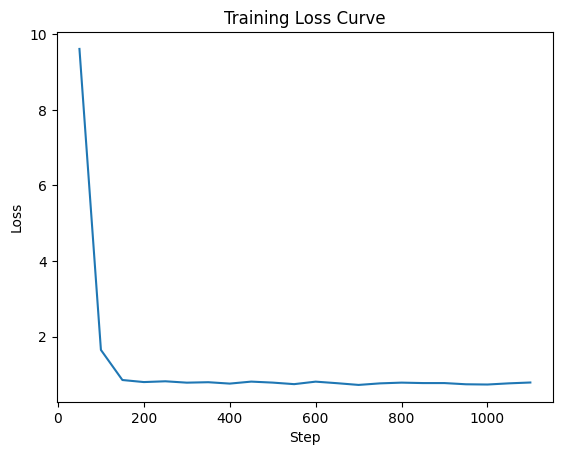

In [ ]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
# Let the trainer make the predictions on the entire test set
finetuned_llama_0_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=0), tokenizer, lora_model) for i in range(len(df_test))]
finetuned_llama_0_shot_predictions

[{' negative': 0.1751067042350769,
  ' neutral': 0.3707009553909302,
  ' positive': 0.45419228076934814},
 {' negative': 0.06644804030656815,
  ' neutral': 0.29318249225616455,
  ' positive': 0.6403694748878479},
 {' negative': 0.5813274383544922,
  ' neutral': 0.31606224179267883,
  ' positive': 0.10261040180921555},
 {' negative': 0.12353341281414032,
  ' neutral': 0.11973268538713455,
  ' positive': 0.7567338943481445},
 {' negative': 0.09559372067451477,
  ' neutral': 0.12863539159297943,
  ' positive': 0.7757708430290222},
 {' negative': 0.06125935912132263,
  ' neutral': 0.06623715907335281,
  ' positive': 0.8725034594535828},
 {' negative': 0.2343187928199768,
  ' neutral': 0.20357969403266907,
  ' positive': 0.5621015429496765},
 {' negative': 0.3189294636249542,
  ' neutral': 0.3139849305152893,
  ' positive': 0.3670855760574341},
 {' negative': 0.09986236691474915,
  ' neutral': 0.34315013885498047,
  ' positive': 0.5569875836372375},
 {' negative': 0.005541358608752489,
  ' 

In [ ]:
# Convert to a DataFrame accordingly
finetuned_llama_0_shot_predictions_df = pd.DataFrame({"score_list" : finetuned_llama_0_shot_predictions})

finetuned_llama_0_shot_predictions_df["negative_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" negative"])
finetuned_llama_0_shot_predictions_df["neutral_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" neutral"])
finetuned_llama_0_shot_predictions_df["positive_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" positive"])
finetuned_llama_0_shot_predictions_df["overall_score"] = finetuned_llama_0_shot_predictions_df["positive_score"] - finetuned_llama_0_shot_predictions_df["negative_score"]
finetuned_llama_0_shot_predictions_df.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.1751067042350769, ' neutral': ...",0.175107,0.370701,0.454192,0.279086
1,"{' negative': 0.06644804030656815, ' neutral':...",0.066448,0.293182,0.640369,0.573921
2,"{' negative': 0.5813274383544922, ' neutral': ...",0.581327,0.316062,0.102610,-0.478717
3,"{' negative': 0.12353341281414032, ' neutral':...",0.123533,0.119733,0.756734,0.633200
4,"{' negative': 0.09559372067451477, ' neutral':...",0.095594,0.128635,0.775771,0.680177


In [ ]:
# Save the predictions
finetuned_llama_0_shot_predictions_df.loc[:, finetuned_llama_0_shot_predictions_df.columns!= "score_list"].to_csv("sentiment_scores/finetuned_llama_0_shot_predictions.csv", index=False)

In [ ]:
# Get & save the metrics
finetuned_llama_0_shot_metrics = get_metrics(finetuned_llama_0_shot_predictions_df)
pd.DataFrame(finetuned_llama_0_shot_metrics, index=[0]).to_csv("sentiment_scores/finetuned_llama_0_shot_metrics.csv", index=False)
finetuned_llama_0_shot_metrics

{'accuracy': 0.34621808637556667,
 'precision_weighted': 0.5506688513178953,
 'recall_weighted': 0.34621808637556667,
 'f1_weighted': 0.21151117011132764,
 'class_0_precision': np.float64(0.07588532883642496),
 'class_0_recall': np.float64(0.26627218934911245),
 'class_0_f1': np.float64(0.11811023622047244),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.671875),
 'class_1_recall': np.float64(0.01654482493266641),
 'class_1_f1': np.float64(0.03229440480660909),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.38568194680249007),
 'class_2_recall': np.float64(0.9578355586788475),
 'class_2_f1': np.float64(0.5499293927778899),
 'class_2_support': np.int64(1423)}

## 4.3. Fine-tuning w/ QLoRA: 1-shot

In [ ]:
one_shot_train_df = df_train.loc[:, ['text', 'labels']]
one_shot_train_df["text"] = df_train['text'].apply(lambda x: formatted_prompt(x, shots=1))
one_shot_train_df.head()

,text,labels
0,<|begin_of_text|><|start_header_id|>system<|en...,neutral
1,<|begin_of_text|><|start_header_id|>system<|en...,neutral
2,<|begin_of_text|><|start_header_id|>system<|en...,negative
3,<|begin_of_text|><|start_header_id|>system<|en...,neutral
4,<|begin_of_text|><|start_header_id|>system<|en...,neutral


In [ ]:
one_shot_train_df["text"][0] + " " + one_shot_train_df['labels'][0]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:\n\n[TICKER] AMZN | [TITLE] Billionaire David Tepper Has 14% of His Portfolio Invested in These 2 Brilliant Artificial Intelligence (AI) Stocks\nSentiment: positive\n\n[TICKER] AAPL | [TITLE] Warren Buffett Has Sold $133 Billion Worth of Stock in 2024 So Far, but This Small $550 Million Pu

In [ ]:
# Get the tokenized train and test set
tokenized_train_set = TokenizedDataset(data=one_shot_train_df, tokenizer=tokenizer, max_length=350)

In [ ]:
# Reinitialize LoRA model
from peft import LoraConfig, get_peft_model

# Define a LoraConfig for training
lora_config = LoraConfig(
    lora_alpha=8, # alpha/r=1 gives equal voices to the base model and the LoRA adapters
    lora_dropout=0.1,
    target_modules = ["q_proj", "v_proj"],
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [ ]:
# Define the training arguments and the model
llama_1_shot_training_args = TrainingArguments(
    output_dir="./results/llama_1_shot",
    logging_dir="./logs/llama_1_shot",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
llama_1_shot_trainer = Trainer(
    model=lora_model,
    args=llama_1_shot_training_args,
    train_dataset=tokenized_train_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

<ipython-input-86-398d2ee6754c>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  llama_1_shot_trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Train the model
llama_1_shot_trainer.train()

Step,Training Loss
50,8.999400
100,1.368300
150,0.824700
200,0.818700
250,0.834500
300,0.798200
350,0.807800
400,0.770500
450,0.832000
500,0.783200


Step 50, Loss: 8.9994
Step 100, Loss: 1.3683
Step 150, Loss: 0.8247
Step 200, Loss: 0.8187
Step 250, Loss: 0.8345
Step 300, Loss: 0.7982
Step 350, Loss: 0.8078
Step 400, Loss: 0.7705
Step 450, Loss: 0.832
Step 500, Loss: 0.7832
Step 550, Loss: 0.7485
Step 600, Loss: 0.8201
Step 650, Loss: 0.7853
Step 700, Loss: 0.741
Step 750, Loss: 0.7841
Step 800, Loss: 0.7795
Step 850, Loss: 0.7658
Step 900, Loss: 0.7734
Step 950, Loss: 0.7438
Step 1000, Loss: 0.7425
Step 1050, Loss: 0.7694
Step 1100, Loss: 0.7903


TrainOutput(global_step=1105, training_loss=1.1837439597462098, metrics={'train_runtime': 996.7482, 'train_samples_per_second': 17.723, 'train_steps_per_second': 1.109, 'total_flos': 1.04650753095168e+17, 'train_loss': 1.1837439597462098, 'epoch': 5.0})

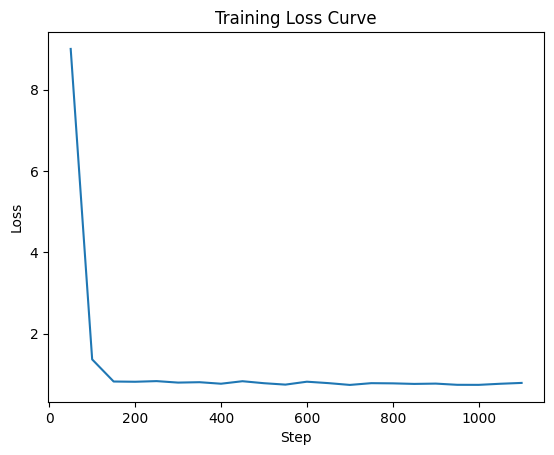

In [ ]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
# Let the trainer make the predictions on the entire test set
finetuned_llama_1_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=1), tokenizer, lora_model) for i in range(len(df_test))]
finetuned_llama_1_shot_predictions

[{' negative': 0.06473836302757263,
  ' neutral': 0.48588836193084717,
  ' positive': 0.4493732750415802},
 {' negative': 0.02094375155866146,
  ' neutral': 0.4173928201198578,
  ' positive': 0.5616634488105774},
 {' negative': 0.13320066034793854,
  ' neutral': 0.7546331882476807,
  ' positive': 0.11216619610786438},
 {' negative': 0.08254943788051605,
  ' neutral': 0.2881258428096771,
  ' positive': 0.629324734210968},
 {' negative': 0.07283429056406021,
  ' neutral': 0.28806519508361816,
  ' positive': 0.6391005516052246},
 {' negative': 0.02228381112217903,
  ' neutral': 0.16724929213523865,
  ' positive': 0.8104668855667114},
 {' negative': 0.12780888378620148,
  ' neutral': 0.41906923055648804,
  ' positive': 0.4531218707561493},
 {' negative': 0.10392457246780396,
  ' neutral': 0.45853671431541443,
  ' positive': 0.4375387728214264},
 {' negative': 0.02769167348742485,
  ' neutral': 0.640184760093689,
  ' positive': 0.3321235179901123},
 {' negative': 0.013771462254226208,
  ' n

In [ ]:
# Convert to a DataFrame accordingly
finetuned_llama_1_shot_predictions_df = pd.DataFrame({"score_list" : finetuned_llama_1_shot_predictions})

finetuned_llama_1_shot_predictions_df["negative_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" negative"])
finetuned_llama_1_shot_predictions_df["neutral_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" neutral"])
finetuned_llama_1_shot_predictions_df["positive_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" positive"])
finetuned_llama_1_shot_predictions_df["overall_score"] = finetuned_llama_1_shot_predictions_df["positive_score"] - finetuned_llama_1_shot_predictions_df["negative_score"]
finetuned_llama_1_shot_predictions_df.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.06473836302757263, ' neutral':...",0.064738,0.485888,0.449373,0.384635
1,"{' negative': 0.02094375155866146, ' neutral':...",0.020944,0.417393,0.561663,0.540720
2,"{' negative': 0.13320066034793854, ' neutral':...",0.133201,0.754633,0.112166,-0.021034
3,"{' negative': 0.08254943788051605, ' neutral':...",0.082549,0.288126,0.629325,0.546775
4,"{' negative': 0.07283429056406021, ' neutral':...",0.072834,0.288065,0.639101,0.566266


In [ ]:
# Save the predictions
finetuned_llama_1_shot_predictions_df.loc[:, finetuned_llama_1_shot_predictions_df.columns != "score_list"].to_csv("sentiment_scores/finetuned_llama_1_shot_predictions.csv", index=False)

In [ ]:
# Get & save the metrics
finetuned_llama_1_shot_metrics = get_metrics(finetuned_llama_1_shot_predictions_df)
pd.DataFrame(finetuned_llama_1_shot_metrics, index=[0]).to_csv("sentiment_scores/finetuned_llama_1_shot_metrics.csv", index=False)
finetuned_llama_1_shot_metrics

{'accuracy': 0.4192316869482224,
 'precision_weighted': 0.5642800384477155,
 'recall_weighted': 0.4192316869482224,
 'f1_weighted': 0.3652978320790609,
 'class_0_precision': np.float64(0.46153846153846156),
 'class_0_recall': np.float64(0.03550295857988166),
 'class_0_f1': np.float64(0.06593406593406594),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.6818181818181818),
 'class_1_recall': np.float64(0.19622931896883417),
 'class_1_f1': np.float64(0.30475052285628923),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.3618075801749271),
 'class_2_recall': np.float64(0.8721011946591708),
 'class_2_f1': np.float64(0.5114362250154544),
 'class_2_support': np.int64(1423)}

# 5. Llama-3.2-1B-Instruct

The code is essentially copy-pasted from part 4, as the implementation process for Llama 3B and Llama 1B are almost identical

In [44]:
# This is to delete CUDA cache
try:
    del tokenizer
except:
    print("tokenizer already deleted")

try:
    del model
except:
    print("model already deleted")

try:
    del lora_model
except:
    print("lora_model already deleted")

import gc
torch.cuda.empty_cache()
gc.collect()

lora_model already deleted


30

In [45]:
from huggingface_hub import login

login(userdata.get("LLAMA_TOKEN"))

In [46]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, BitsAndBytesConfig
import torch

model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    padding_side="left",
)
tokenizer.pad_token_id = tokenizer.bos_token_id

config = AutoConfig.from_pretrained(
    model_name,
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True # Enable CPU offloading, Llama might be heavy
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=config,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [47]:
# Construct the prompt format for model inference
def formatted_prompt(news_headline, shots=0):
    # Define special tokens to be inserted into the prompt
    B_SYS = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
    E_SYS = "<|end_of_text|>"
    B_INST = "<|start_header_id|>user<|end_header_id|>"
    E_INST = "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    system_prompt = (
        "You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. "
        "Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. "
        "You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. "
        "The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. " # The space before each label is intentional
        "Answer with only one of these three labels and nothing else."
    )

    if shots == 0:
        user_prompt = (
            "Classify the sentiment of the following financial news headline into one of the following: "
            "' positive', ' neutral', or ' negative'.\n\n"
            f"{news_headline}\nSentiment:"
        )
    elif shots == 1:
        user_prompt = (
            "Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:\n\n"
            f"{one_shot_news['annot_title'][0]}\nSentiment: {one_shot_news['sentiment'][0]}\n\n"
            f"{one_shot_news['annot_title'][1]}\nSentiment: {one_shot_news['sentiment'][1]}\n\n"
            f"{one_shot_news['annot_title'][2]}\nSentiment: {one_shot_news['sentiment'][2]}\n\n"
            "Classify the sentiment of the following financial news headline into one of the following: "
            "' positive', ' neutral', or ' negative'.\n\n"
            f"{news_headline}\nSentiment:"
        )
    else:
        print("Unsupported number of shots")
        return None

    return f"{B_SYS}{system_prompt}{E_SYS}{B_INST}{user_prompt}{E_INST}"

In [48]:
# Try one 1 entry
print(formatted_prompt(df_test['text'].iloc[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Classify the sentiment of the following financial news headline into one of the following: ' positive', ' neutral', or ' negative'.

[TICKER] NFLX | [TITLE] Should You Buy Netflix Stock Before December 25?
Sentiment:<|eot_id|><|start_header_id|>assistant<|end_header_id|>


In [49]:
print(formatted_prompt(df_test['text'].iloc[2], shots=1))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:

[TICKER] AMZN | [TITLE] Billionaire David Tepper Has 14% of His Portfolio Invested in These 2 Brilliant Artificial Intelligence (AI) Stocks
Sentiment: positive

[TICKER] AAPL | [TITLE] Warren Buffett Has Sold $133 Billion Worth of Stock in 2024 So Far, but This Small $550 Million Purchase

In [50]:
# Demonstrating the expected behavior of Llama tokenizer: It tokenizes the space before each word as well
# I spent an UNGODLY amount of time working this out
encoding = tokenizer("The product was great. Sentiment: positive", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

encoding = tokenizer(" positive", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

encoding = tokenizer(" Sentiment:", return_tensors="pt")
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0][-10:]))

print(tokenizer(":", return_tensors="pt"))

['<|begin_of_text|>', 'The', 'Ġproduct', 'Ġwas', 'Ġgreat', '.', 'ĠSent', 'iment', ':', 'Ġpositive']
['<|begin_of_text|>', 'Ġpositive']
['<|begin_of_text|>', 'ĠSent', 'iment', ':']
{'input_ids': tensor([[128000,     25]]), 'attention_mask': tensor([[1, 1]])}


In [51]:
# Get the tokenized label ids
labels = [" negative", " neutral", " positive"] # Add space before word because Llama tokenizer tokenize the words this way. Seriously, WHY?????
tokenized_labels = [tokenizer(label, add_special_tokens=False) for label in labels]
tokenized_label_ids = [tokenized_label.input_ids[0] for tokenized_label in tokenized_labels]
tokenized_label_ids_to_classes = {tok_id: i for i, tok_id in enumerate(tokenized_label_ids)}

In [52]:
tokenized_label_ids

[8389, 21277, 6928]

In [53]:
tokenized_label_ids_to_classes

{8389: 0, 21277: 1, 6928: 2}

## 5.1. Out-of-the-box

In [54]:
tokenized_label_ids

[8389, 21277, 6928]

In [55]:
import torch.nn.functional as F

# Try on 1 entry first
prompt = formatted_prompt(df_test['text'].iloc[0])

log_likelihoods = []

# Tokenize the prompt
prompt_inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Get logits of all English vocab for the next token prediction
with torch.no_grad():
    outputs = model(**prompt_inputs)
    next_token_logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]
    log_probs = F.log_softmax(next_token_logits, dim=-1)

# Get the log-prob of the 3 labels
for tokenized_label_id in tokenized_label_ids:
    log_likelihoods.append(log_probs[0, tokenized_label_id].item())

# Convert to probabilities
probs = F.softmax(torch.tensor(log_likelihoods), dim=0)

# Output
for label, prob in zip(labels, probs):
    print(f"{label}: {prob.item():.4f}")

 negative: 0.0540
 neutral: 0.5625
 positive: 0.3836


In [56]:
# Create a function to automate the above process
import torch.nn.functional as F

def get_sentiment_scores(prompt, tokenizer, model):
    log_likelihoods = []

    # Tokenize the prompt
    prompt_inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Get logits of all English vocab for the next token prediction
    with torch.no_grad():
        outputs = model(**prompt_inputs)
        next_token_logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]
        log_probs = F.log_softmax(next_token_logits, dim=-1)

    # Get the log-prob of the 3 labels
    for tokenized_label_id in tokenized_label_ids:
        log_likelihoods.append(log_probs[0, tokenized_label_id].item())

    # Convert to probabilities
    probs = F.softmax(torch.tensor(log_likelihoods), dim=0)

    # Return a dictionary with the label and the probs attached
    return {label: prob.item() for label, prob in zip(labels, probs)} # Note that labels is defined outside of the function

In [57]:
# Apply zero-shot prediction on the entire test set
# This will take a while
raw_llama_0_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=0), tokenizer, model) for i in range(len(df_test))]

In [58]:
# Apply one-shot prediction on the entire test set
# This will also take a while
raw_llama_1_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=1), tokenizer, model) for i in range(len(df_test))]

In [59]:
# Transform raw_llama_0_shot_predictions into a dataset
raw_llama_0_shot_predictions = pd.DataFrame({"score_list": raw_llama_0_shot_predictions})
raw_llama_0_shot_predictions.head()

,score_list
0,"{' negative': 0.05397753790020943, ' neutral':..."
1,"{' negative': 0.050943538546562195, ' neutral'..."
2,"{' negative': 0.04702480882406235, ' neutral':..."
3,"{' negative': 0.02062184549868107, ' neutral':..."
4,"{' negative': 0.016722315922379494, ' neutral'..."


In [60]:
raw_llama_0_shot_predictions["negative_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" negative"])
raw_llama_0_shot_predictions["neutral_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" neutral"])
raw_llama_0_shot_predictions["positive_score"] = raw_llama_0_shot_predictions["score_list"].apply(lambda x: x[" positive"])
raw_llama_0_shot_predictions["overall_score"] = raw_llama_0_shot_predictions["positive_score"] - raw_llama_0_shot_predictions["negative_score"]
raw_llama_0_shot_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.05397753790020943, ' neutral':...",0.053978,0.562459,0.383564,0.329586
1,"{' negative': 0.050943538546562195, ' neutral'...",0.050944,0.388374,0.560683,0.509739
2,"{' negative': 0.04702480882406235, ' neutral':...",0.047025,0.634120,0.318855,0.271831
3,"{' negative': 0.02062184549868107, ' neutral':...",0.020622,0.646558,0.332820,0.312198
4,"{' negative': 0.016722315922379494, ' neutral'...",0.016722,0.689174,0.294103,0.277381


In [61]:
# Save the predicted results
raw_llama_0_shot_predictions.loc[:, raw_llama_0_shot_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_llama_1B_0_shot_predictions.csv", index=False)

In [62]:
# Get & save the performance metrics of the model
raw_llama_0_shot_metrics = get_metrics(raw_llama_0_shot_predictions)
pd.DataFrame(raw_llama_0_shot_metrics, index=[0]).to_csv("sentiment_scores/raw_llama_1B_0_shot_metrics.csv", index=False)
raw_llama_0_shot_metrics

{'accuracy': 0.5724170842281079,
 'precision_weighted': 0.5087767976743117,
 'recall_weighted': 0.5724170842281079,
 'f1_weighted': 0.525570056651609,
 'class_0_precision': np.float64(0.0),
 'class_0_recall': np.float64(0.0),
 'class_0_f1': np.float64(0.0),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.6227474150664697),
 'class_1_recall': np.float64(0.8110811850711812),
 'class_1_f1': np.float64(0.7045454545454546),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.3610421836228288),
 'class_2_recall': np.float64(0.2044975404075896),
 'class_2_f1': np.float64(0.2611036339165545),
 'class_2_support': np.int64(1423)}

In [63]:
raw_llama_0_shot_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_list      4191 non-null   object 
 1   negative_score  4191 non-null   float64
 2   neutral_score   4191 non-null   float64
 3   positive_score  4191 non-null   float64
 4   overall_score   4191 non-null   float64
dtypes: float64(4), object(1)
memory usage: 163.8+ KB


In [64]:
# Transform raw_llama_1_shot_predictions similarly
raw_llama_1_shot_predictions = pd.DataFrame({"score_list": raw_llama_1_shot_predictions})

raw_llama_1_shot_predictions["negative_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" negative"])
raw_llama_1_shot_predictions["neutral_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" neutral"])
raw_llama_1_shot_predictions["positive_score"] = raw_llama_1_shot_predictions["score_list"].apply(lambda x: x[" positive"])
raw_llama_1_shot_predictions["overall_score"] = raw_llama_1_shot_predictions["positive_score"] - raw_llama_1_shot_predictions["negative_score"]
raw_llama_1_shot_predictions.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.0341225266456604, ' neutral': ...",0.034123,0.456554,0.509323,0.475201
1,"{' negative': 0.02521640993654728, ' neutral':...",0.025216,0.214459,0.760324,0.735108
2,"{' negative': 0.034232694655656815, ' neutral'...",0.034233,0.430278,0.535489,0.501257
3,"{' negative': 0.05440456420183182, ' neutral':...",0.054405,0.421291,0.524305,0.469900
4,"{' negative': 0.046419259160757065, ' neutral'...",0.046419,0.302692,0.650889,0.604470


In [65]:
# Save the predicted results & performance metrics of the model
raw_llama_1_shot_predictions.loc[:, raw_llama_1_shot_predictions.columns != "score_list"].to_csv("sentiment_scores/raw_llama_1B_1_shot_predictions.csv", index=False)

raw_llama_1_shot_metrics = get_metrics(raw_llama_1_shot_predictions)
pd.DataFrame(raw_llama_1_shot_metrics, index=[0]).to_csv("sentiment_scores/raw_llama_1B_1_shot_metrics.csv", index=False)
raw_llama_1_shot_metrics

{'accuracy': 0.4614650441422095,
 'precision_weighted': 0.5882493768361391,
 'recall_weighted': 0.4614650441422095,
 'f1_weighted': 0.4298155076649104,
 'class_0_precision': np.float64(0.0),
 'class_0_recall': np.float64(0.0),
 'class_0_f1': np.float64(0.0),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.7434077079107505),
 'class_1_recall': np.float64(0.28203155059638324),
 'class_1_f1': np.float64(0.40892608089260807),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.3747269890795632),
 'class_2_recall': np.float64(0.8439915671117357),
 'class_2_f1': np.float64(0.5190146931719966),
 'class_2_support': np.int64(1423)}

In [66]:
raw_llama_1_shot_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191 entries, 0 to 4190
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_list      4191 non-null   object 
 1   negative_score  4191 non-null   float64
 2   neutral_score   4191 non-null   float64
 3   positive_score  4191 non-null   float64
 4   overall_score   4191 non-null   float64
dtypes: float64(4), object(1)
memory usage: 163.8+ KB


## 5.2. Fine-tuning w/ QLoRA: 0-shot

Note that for our approach here, we're only fine-tuning the LoRA adapters and not the base model's weights

In [67]:
from transformers import Trainer, TrainingArguments, TrainerCallback, DataCollatorWithPadding

# Define a custom callback that collects loss value at each logging step
class LossPlotCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"Step {state.global_step}, Loss: {logs['loss']}")
            self.losses.append((state.global_step, logs["loss"]))

# Define a data collator to batch samples during training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [68]:
zero_shot_train_df = df_train.loc[:, ['text', 'labels']]
zero_shot_train_df["text"] = df_train['text'].apply(lambda x: formatted_prompt(x, shots=0))
zero_shot_train_df.head()

,text,labels
0,<|begin_of_text|><|start_header_id|>system<|en...,neutral
1,<|begin_of_text|><|start_header_id|>system<|en...,neutral
2,<|begin_of_text|><|start_header_id|>system<|en...,negative
3,<|begin_of_text|><|start_header_id|>system<|en...,neutral
4,<|begin_of_text|><|start_header_id|>system<|en...,neutral


In [69]:
from torch.utils.data import Dataset

class TokenizedDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        prompt = self.data.loc[idx, "text"]
        label = self.data.loc[idx, "labels"]  # Single-token label
        full_text = prompt + " " + label # During training, we need the entire sequence too

        encoder = tokenizer(full_text, return_tensors="pt", padding="max_length", truncation=True, add_special_tokens=False, max_length=self.max_length)
        input_ids = encoder["input_ids"].squeeze()
        attention_mask = encoder["attention_mask"].squeeze()

        # Only calculate loss on final token (the label)
        label_ids = input_ids.clone()
        label_ids[:-1] = -100

        # Mask final token if it's not a valid label
        if label_ids[-1].item() not in tokenized_label_ids:
            label_ids[-1] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": label_ids,
        }

    def __len__(self):
        return len(self.data)

In [70]:
# Get the tokenized train set
tokenized_train_set = TokenizedDataset(data=zero_shot_train_df, tokenizer=tokenizer, max_length=256)

In [71]:
!pip install peft

In [72]:
# Define LoRA config for training
from peft import LoraConfig, get_peft_model

# Define a LoraConfig for training
lora_config = LoraConfig(
    lora_alpha=8, # alpha/r=1 gives equal voices to the base model and the LoRA adapters
    lora_dropout=0.1,
    target_modules = ["q_proj", "v_proj"],
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


In [73]:
# Define the training arguments and the model
# Identical to finbert_training_args except for the dirs
llama_0_shot_training_args = TrainingArguments(
    output_dir="./results/llama_1B_0_shot",
    logging_dir="./logs/llama_1B_0_shot",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
llama_0_shot_trainer = Trainer(
    model=lora_model,
    args=llama_0_shot_training_args,
    train_dataset=tokenized_train_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

<ipython-input-73-5b2b8b3904be>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  llama_0_shot_trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [74]:
# Train the model
llama_0_shot_trainer.train()

Step,Training Loss
50,5.082900
100,1.713100
150,0.967900
200,0.911300
250,0.940600
300,0.873700
350,0.840500
400,0.819800
450,0.897900
500,0.834000


Step 50, Loss: 5.0829
Step 100, Loss: 1.7131
Step 150, Loss: 0.9679
Step 200, Loss: 0.9113
Step 250, Loss: 0.9406
Step 300, Loss: 0.8737
Step 350, Loss: 0.8405
Step 400, Loss: 0.8198
Step 450, Loss: 0.8979
Step 500, Loss: 0.834
Step 550, Loss: 0.8268
Step 600, Loss: 0.8637
Step 650, Loss: 0.8392
Step 700, Loss: 0.8034
Step 750, Loss: 0.8285
Step 800, Loss: 0.8219
Step 850, Loss: 0.8013
Step 900, Loss: 0.8461
Step 950, Loss: 0.8026
Step 1000, Loss: 0.7909
Step 1050, Loss: 0.8153
Step 1100, Loss: 0.8308


TrainOutput(global_step=1105, training_loss=1.0783562560966111, metrics={'train_runtime': 902.1434, 'train_samples_per_second': 19.581, 'train_steps_per_second': 1.225, 'total_flos': 2.64279184637952e+16, 'train_loss': 1.0783562560966111, 'epoch': 5.0})

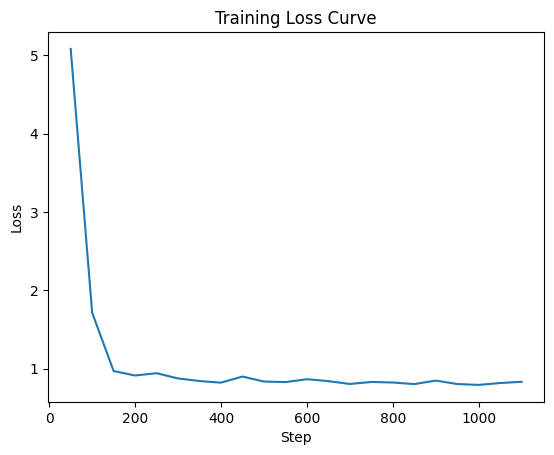

In [75]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [76]:
# Let the trainer make the predictions on the entire test set
finetuned_llama_0_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=0), tokenizer, lora_model) for i in range(len(df_test))]
finetuned_llama_0_shot_predictions

[{' negative': 0.06745198369026184,
  ' neutral': 0.6551430225372314,
  ' positive': 0.2774049937725067},
 {' negative': 0.0626479908823967,
  ' neutral': 0.6630872488021851,
  ' positive': 0.2742648124694824},
 {' negative': 0.0830036848783493,
  ' neutral': 0.6842066645622253,
  ' positive': 0.23278957605361938},
 {' negative': 0.024715738371014595,
  ' neutral': 0.2806554138660431,
  ' positive': 0.694628894329071},
 {' negative': 0.01983274705708027,
  ' neutral': 0.3078220784664154,
  ' positive': 0.6723452210426331},
 {' negative': 0.05923786386847496,
  ' neutral': 0.2938658595085144,
  ' positive': 0.646896243095398},
 {' negative': 0.10477549582719803,
  ' neutral': 0.3462401032447815,
  ' positive': 0.5489843487739563},
 {' negative': 0.11052457243204117,
  ' neutral': 0.5569220781326294,
  ' positive': 0.33255335688591003},
 {' negative': 0.07679034769535065,
  ' neutral': 0.6530828475952148,
  ' positive': 0.2701267898082733},
 {' negative': 0.04184107109904289,
  ' neutral

In [77]:
# Convert to a DataFrame accordingly
finetuned_llama_0_shot_predictions_df = pd.DataFrame({"score_list" : finetuned_llama_0_shot_predictions})

finetuned_llama_0_shot_predictions_df["negative_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" negative"])
finetuned_llama_0_shot_predictions_df["neutral_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" neutral"])
finetuned_llama_0_shot_predictions_df["positive_score"] = finetuned_llama_0_shot_predictions_df["score_list"].apply(lambda x: x[" positive"])
finetuned_llama_0_shot_predictions_df["overall_score"] = finetuned_llama_0_shot_predictions_df["positive_score"] - finetuned_llama_0_shot_predictions_df["negative_score"]
finetuned_llama_0_shot_predictions_df.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.06745198369026184, ' neutral':...",0.067452,0.655143,0.277405,0.209953
1,"{' negative': 0.0626479908823967, ' neutral': ...",0.062648,0.663087,0.274265,0.211617
2,"{' negative': 0.0830036848783493, ' neutral': ...",0.083004,0.684207,0.232790,0.149786
3,"{' negative': 0.024715738371014595, ' neutral'...",0.024716,0.280655,0.694629,0.669913
4,"{' negative': 0.01983274705708027, ' neutral':...",0.019833,0.307822,0.672345,0.652512


In [78]:
# Save the predictions
finetuned_llama_0_shot_predictions_df.loc[:, finetuned_llama_0_shot_predictions_df.columns!= "score_list"].to_csv("sentiment_scores/finetuned_llama_1B_0_shot_predictions.csv", index=False)

In [79]:
# Get & save the metrics
finetuned_llama_0_shot_metrics = get_metrics(finetuned_llama_0_shot_predictions_df)
pd.DataFrame(finetuned_llama_0_shot_metrics, index=[0]).to_csv("sentiment_scores/finetuned_llama_1B_0_shot_metrics.csv", index=False)
finetuned_llama_0_shot_metrics

{'accuracy': 0.4881889763779528,
 'precision_weighted': 0.49749237821341874,
 'recall_weighted': 0.4881889763779528,
 'f1_weighted': 0.48729081214957937,
 'class_0_precision': np.float64(0.0),
 'class_0_recall': np.float64(0.0),
 'class_0_f1': np.float64(0.0),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.6124551971326165),
 'class_1_recall': np.float64(0.525971527510581),
 'class_1_f1': np.float64(0.5659283792175533),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.34660541092394076),
 'class_2_recall': np.float64(0.47716092761770906),
 'class_2_f1': np.float64(0.4015375517445299),
 'class_2_support': np.int64(1423)}

## 5.3. Fine-tuning w/ QLoRA: 1-shot

In [80]:
one_shot_train_df = df_train.loc[:, ['text', 'labels']]
one_shot_train_df["text"] = df_train['text'].apply(lambda x: formatted_prompt(x, shots=1))
one_shot_train_df.head()

,text,labels
0,<|begin_of_text|><|start_header_id|>system<|en...,neutral
1,<|begin_of_text|><|start_header_id|>system<|en...,neutral
2,<|begin_of_text|><|start_header_id|>system<|en...,negative
3,<|begin_of_text|><|start_header_id|>system<|en...,neutral
4,<|begin_of_text|><|start_header_id|>system<|en...,neutral


In [81]:
one_shot_train_df["text"][0] + " " + one_shot_train_df['labels'][0]

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a seasoned financial analyst with years of experience in market psychology and sentiment analysis. Your task is to impartially assess the sentiment of news headlines in relation to specific stocks. You must ignore personal bias and consider how a typical investor or the market in general might respond to the news. The sentiment should be one of the following: ' positive', ' neutral', or ' negative'. Answer with only one of these three labels and nothing else.<|end_of_text|><|start_header_id|>user<|end_header_id|>Here are some examples of financial news headlines with annotated stock at the beginning and their corresponding sentiments:\n\n[TICKER] AMZN | [TITLE] Billionaire David Tepper Has 14% of His Portfolio Invested in These 2 Brilliant Artificial Intelligence (AI) Stocks\nSentiment: positive\n\n[TICKER] AAPL | [TITLE] Warren Buffett Has Sold $133 Billion Worth of Stock in 2024 So Far, but This Small $550 Million Pu

In [82]:
# Get the tokenized train and test set
tokenized_train_set = TokenizedDataset(data=one_shot_train_df, tokenizer=tokenizer, max_length=350)

In [83]:
# Reinitialize LoRA model
from peft import LoraConfig, get_peft_model

# Define a LoraConfig for training
lora_config = LoraConfig(
    lora_alpha=8, # alpha/r=1 gives equal voices to the base model and the LoRA adapters
    lora_dropout=0.1,
    target_modules = ["q_proj", "v_proj"],
    r=8,
    bias="none",
    task_type="CAUSAL_LM"
)

lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 851,968 || all params: 1,236,666,368 || trainable%: 0.0689


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [84]:
# Define the training arguments and the model
llama_1_shot_training_args = TrainingArguments(
    output_dir="./results/llama_1B_1_shot",
    logging_dir="./logs/llama_1B_1_shot",
    logging_steps=50,
    save_strategy="no",
    eval_strategy="no",
    gradient_accumulation_steps = 1,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    fp16=True,
    learning_rate=2e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.03,
    max_grad_norm = 1.0,
    weight_decay = 0.01,
    load_best_model_at_end=False,
    report_to="tensorboard",
)

loss_callback = LossPlotCallback()

# Define the trainer
llama_1_shot_trainer = Trainer(
    model=lora_model,
    args=llama_1_shot_training_args,
    train_dataset=tokenized_train_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_callback]
)

<ipython-input-84-67becab63a89>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  llama_1_shot_trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [85]:
# Train the model
llama_1_shot_trainer.train()

Step,Training Loss
50,13.514900
100,2.169500
150,0.942600
200,0.885100
250,0.920000
300,0.872600
350,0.837000
400,0.828800
450,0.883700
500,0.834600


Step 50, Loss: 13.5149
Step 100, Loss: 2.1695
Step 150, Loss: 0.9426
Step 200, Loss: 0.8851
Step 250, Loss: 0.92
Step 300, Loss: 0.8726
Step 350, Loss: 0.837
Step 400, Loss: 0.8288
Step 450, Loss: 0.8837
Step 500, Loss: 0.8346
Step 550, Loss: 0.8234
Step 600, Loss: 0.8613
Step 650, Loss: 0.8369
Step 700, Loss: 0.8158
Step 750, Loss: 0.8199
Step 800, Loss: 0.8189
Step 850, Loss: 0.8094
Step 900, Loss: 0.8379
Step 950, Loss: 0.8116
Step 1000, Loss: 0.7998
Step 1050, Loss: 0.8128
Step 1100, Loss: 0.8315


TrainOutput(global_step=1105, training_loss=1.4771687982308919, metrics={'train_runtime': 1283.6654, 'train_samples_per_second': 13.761, 'train_steps_per_second': 0.861, 'total_flos': 3.613191977472e+16, 'train_loss': 1.4771687982308919, 'epoch': 5.0})

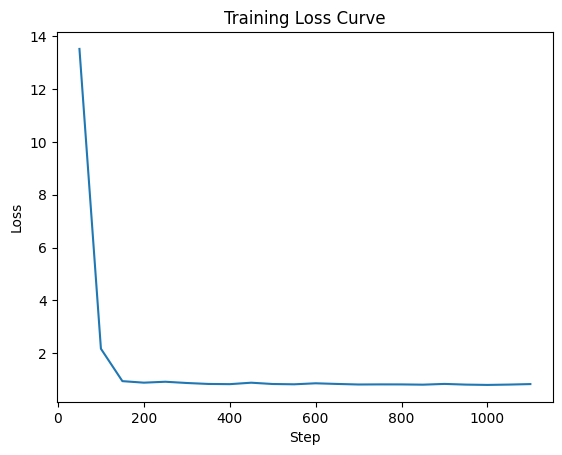

In [86]:
# Plot the training loss curve
steps, losses = zip(*loss_callback.losses)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [87]:
# Let the trainer make the predictions on the entire test set
finetuned_llama_1_shot_predictions = [get_sentiment_scores(formatted_prompt(df_test['text'].iloc[i], shots=1), tokenizer, lora_model) for i in range(len(df_test))]
finetuned_llama_1_shot_predictions

[{' negative': 0.015633592382073402,
  ' neutral': 0.30914080142974854,
  ' positive': 0.6752256155014038},
 {' negative': 0.010436378419399261,
  ' neutral': 0.19846458733081818,
  ' positive': 0.7910990118980408},
 {' negative': 0.017783761024475098,
  ' neutral': 0.3252311646938324,
  ' positive': 0.6569850444793701},
 {' negative': 0.005398326553404331,
  ' neutral': 0.16150349378585815,
  ' positive': 0.8330981731414795},
 {' negative': 0.004360856954008341,
  ' neutral': 0.08292869478464127,
  ' positive': 0.9127103686332703},
 {' negative': 0.009606295265257359,
  ' neutral': 0.1290338635444641,
  ' positive': 0.8613598346710205},
 {' negative': 0.02215196192264557,
  ' neutral': 0.29408347606658936,
  ' positive': 0.6837645173072815},
 {' negative': 0.013325396925210953,
  ' neutral': 0.3545754849910736,
  ' positive': 0.6320991516113281},
 {' negative': 0.006696613971143961,
  ' neutral': 0.3516157865524292,
  ' positive': 0.6416875720024109},
 {' negative': 0.0039745089598000

In [88]:
# Convert to a DataFrame accordingly
finetuned_llama_1_shot_predictions_df = pd.DataFrame({"score_list" : finetuned_llama_1_shot_predictions})

finetuned_llama_1_shot_predictions_df["negative_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" negative"])
finetuned_llama_1_shot_predictions_df["neutral_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" neutral"])
finetuned_llama_1_shot_predictions_df["positive_score"] = finetuned_llama_1_shot_predictions_df["score_list"].apply(lambda x: x[" positive"])
finetuned_llama_1_shot_predictions_df["overall_score"] = finetuned_llama_1_shot_predictions_df["positive_score"] - finetuned_llama_1_shot_predictions_df["negative_score"]
finetuned_llama_1_shot_predictions_df.head()

,score_list,negative_score,neutral_score,positive_score,overall_score
0,"{' negative': 0.015633592382073402, ' neutral'...",0.015634,0.309141,0.675226,0.659592
1,"{' negative': 0.010436378419399261, ' neutral'...",0.010436,0.198465,0.791099,0.780663
2,"{' negative': 0.017783761024475098, ' neutral'...",0.017784,0.325231,0.656985,0.639201
3,"{' negative': 0.005398326553404331, ' neutral'...",0.005398,0.161503,0.833098,0.827700
4,"{' negative': 0.004360856954008341, ' neutral'...",0.004361,0.082929,0.912710,0.908350


In [89]:
# Save the predictions
finetuned_llama_1_shot_predictions_df.loc[:, finetuned_llama_1_shot_predictions_df.columns != "score_list"].to_csv("sentiment_scores/finetuned_llama_1B_1_shot_predictions.csv", index=False)

In [90]:
# Get & save the metrics
finetuned_llama_1_shot_metrics = get_metrics(finetuned_llama_1_shot_predictions_df)
pd.DataFrame(finetuned_llama_1_shot_metrics, index=[0]).to_csv("sentiment_scores/finetuned_llama_1B_1_shot_metrics.csv", index=False)
finetuned_llama_1_shot_metrics

{'accuracy': 0.3478883321403006,
 'precision_weighted': 0.6518370718380592,
 'recall_weighted': 0.3478883321403006,
 'f1_weighted': 0.19095345694567958,
 'class_0_precision': np.float64(0.0),
 'class_0_recall': np.float64(0.0),
 'class_0_f1': np.float64(0.0),
 'class_0_support': np.int64(169),
 'class_1_precision': np.float64(0.8636363636363636),
 'class_1_recall': np.float64(0.014621008080030782),
 'class_1_f1': np.float64(0.028755202421490732),
 'class_1_support': np.int64(2599),
 'class_2_precision': np.float64(0.34241620448517),
 'class_2_recall': np.float64(0.9978917779339423),
 'class_2_f1': np.float64(0.5098743267504489),
 'class_2_support': np.int64(1423)}